# Masked Flow Matching with variable-cardinality sets

Demonstrate the `masked_fm_loss` and `masked_sample` for generating variable-size sets of 2D data samples. Each event has a different numberof objects padded to a common `N_max`; the mask keeps padding out of the loss and out of the ODE trajectory.

In [15]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from nami import StandardNormal, RK4, masked_fm_loss, masked_sample

## toy: variable-size particle events

Each event contains 3-8 "particles" sampled on a circle of radius 1, with a little Gaussian noise. Pad every event to `N_MAX = 8` and build a binary mask.

In [16]:
N_MAX = 8      # maximum particles per event
DIM = 2        # features per particle (x, y)
N_EVENTS = 10000 # training set size

torch.manual_seed(0)

def make_event(n_particles, n_max=N_MAX):
    """Return (padded_particles, mask) for one event."""
    theta = torch.linspace(0, 2 * torch.pi, n_particles + 1)[:-1]
    pts = torch.stack([theta.cos(), theta.sin()], dim=-1)  # (n, 2)
    pts = pts + 0.05 * torch.randn_like(pts)               # small noise
    padded = torch.zeros(n_max, DIM)
    padded[:n_particles] = pts
    mask = torch.zeros(n_max)
    mask[:n_particles] = 1.0
    return padded, mask

cardinalities = torch.randint(3, N_MAX + 1, (N_EVENTS,))
events, masks = zip(*[make_event(int(n)) for n in cardinalities])
x_data = torch.stack(events)   # (N_EVENTS, N_MAX, DIM)
mask_data = torch.stack(masks) # (N_EVENTS, N_MAX)

print(f"Data shape : {x_data.shape}")

print(f"Mask shape : {mask_data.shape}")
print(f"Cardinality range: {cardinalities.min().item()} {cardinalities.max().item()}")

Data shape : torch.Size([10000, 8, 2])
Mask shape : torch.Size([10000, 8])
Cardinality range: 3 8


Quick look at a few training events (real particles as dots, padding absent):

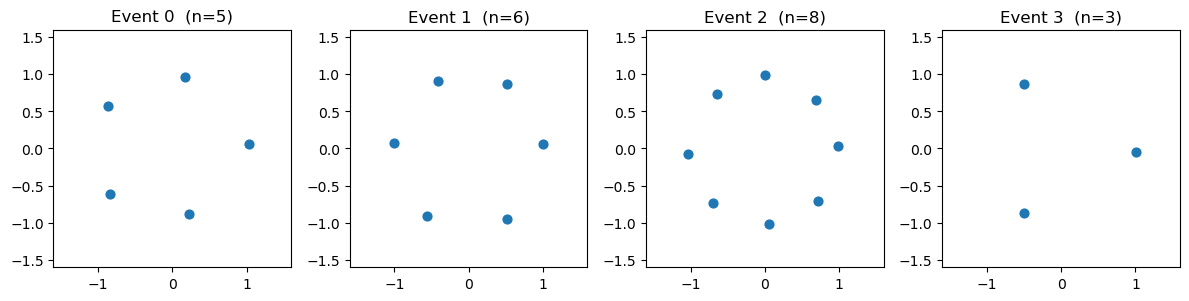

In [17]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for ax, idx in zip(axes, range(4)):
    n = int(mask_data[idx].sum())
    pts = x_data[idx, :n]
    ax.scatter(pts[:, 0], pts[:, 1], s=40)
    ax.set_title(f"Event {idx}  (n={n})")
    ax.set_xlim(-1.6, 1.6); ax.set_ylim(-1.6, 1.6)
    ax.set_aspect("equal")
plt.tight_layout()
plt.show()

### Velocity field

A small MLP that flattens the `(N_MAX, DIM)` event, concatenates time, and predicts a velocity for every particle slot.  `event_ndim = 2` tells nami the last two dims form one data point.

In [18]:
class ParticleField(nn.Module):
    def __init__(self, n_max, dim, hidden=128):
        super().__init__()
        flat = n_max * dim
        self.net = nn.Sequential(
            nn.Linear(flat + 1, hidden),
            nn.SiLU(),
            nn.Linear(hidden, hidden),
            nn.SiLU(),
            nn.Linear(hidden, flat),
        )
        self._shape = (n_max, dim)

    @property
    def event_ndim(self):
        return 2

    def forward(self, x, t, c=None):
        flat = x.reshape(*x.shape[:-2], -1)
        t_exp = t.unsqueeze(-1).expand(*flat.shape[:-1], 1)
        out = self.net(torch.cat([flat, t_exp], dim=-1))
        return out.reshape_as(x)


field = ParticleField(N_MAX, DIM)
print(f"Parameters: {sum(p.numel() for p in field.parameters()):,}")

Parameters: 20,880


### Training with `masked_fm_loss`

Padding should never contribute to the gradient.

Step     1/5000  loss = 1.4380
Step   500/5000  loss = 0.3670
Step  1000/5000  loss = 0.2752
Step  1500/5000  loss = 0.3172
Step  2000/5000  loss = 0.3152
Step  2500/5000  loss = 0.3075
Step  3000/5000  loss = 0.3562
Step  3500/5000  loss = 0.3054
Step  4000/5000  loss = 0.2698
Step  4500/5000  loss = 0.2913
Step  5000/5000  loss = 0.2762


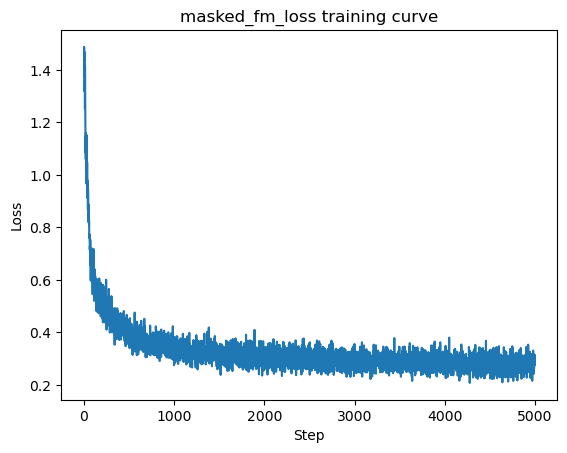

In [19]:
optimizer = torch.optim.Adam(field.parameters(), lr=1e-3)
steps = 5000
losses = []
for step in range(1, steps + 1):
    idx = torch.randint(0, N_EVENTS, (128,))
    x_target = x_data[idx]
    x_source = torch.randn_like(x_target)
    m = mask_data[idx]

    loss = masked_fm_loss(field, x_target, x_source, m)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    if step % 500 == 0 or step == 1:
        print(f"Step {step:>5}/{steps}  loss = {loss.item():.4f}")

plt.plot(losses)
plt.xlabel("Step"); plt.ylabel("Loss")
plt.title("masked_fm_loss training curve")
plt.show()

### sample with `masked_sample`

generate events with different cardinalities by passing per-event masks. Padded positions should stay exactly zero throughout integration.

In [20]:
base = StandardNormal(event_shape=(N_MAX, DIM))
solver = RK4(steps=50)

# build masks for 8 samples with cardinalities 3,4,5,6,7,8,5,4
sample_ns = [3, 4, 5, 6, 7, 8, 5, 4]
sample_mask = torch.zeros(len(sample_ns), N_MAX)
for i, n in enumerate(sample_ns):
    sample_mask[i, :n] = 1.0

with torch.no_grad():
    samples = masked_sample(
        field, base, solver, sample_mask,
        sample_shape=(len(sample_ns),),
    )

print(f"Samples shape: {samples.shape}")
print(f"Padding is zero: {torch.all(samples[0, sample_ns[0]:] == 0).item()}")

Samples shape: torch.Size([8, 8, 2])
Padding is zero: True


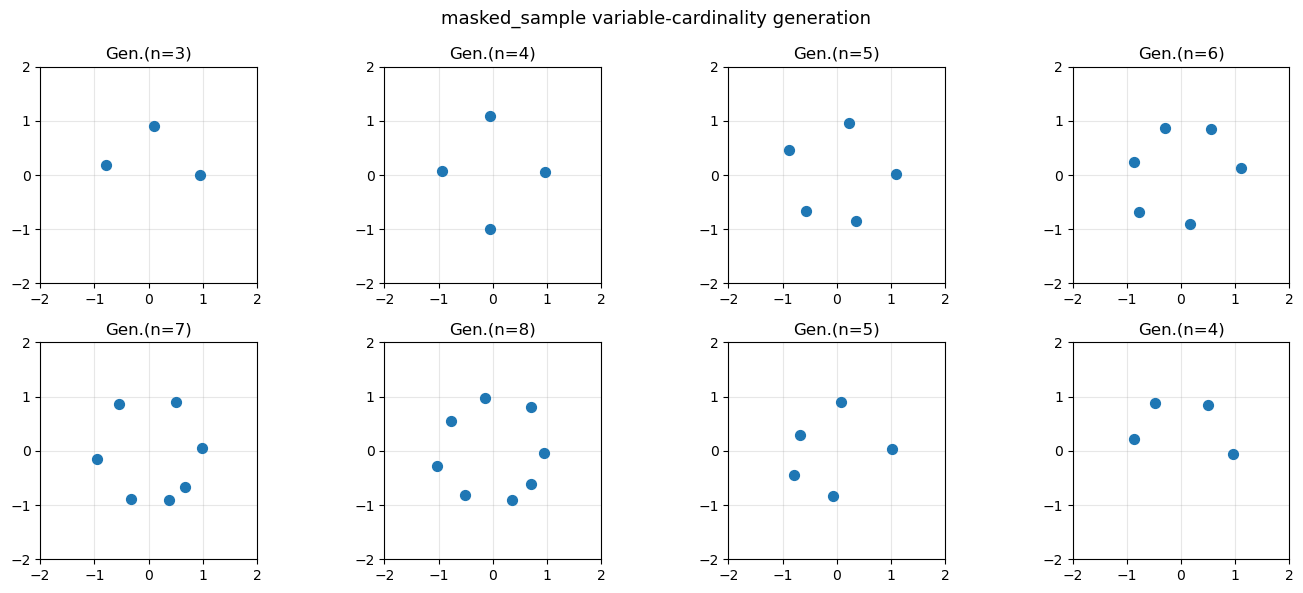

In [21]:
fig, axes = plt.subplots(2, 4, figsize=(14, 6))
for ax, i in zip(axes.flat, range(len(sample_ns))):
    n = sample_ns[i]
    pts = samples[i, :n].numpy()
    ax.scatter(pts[:, 0], pts[:, 1], s=50, zorder=3)
    ax.set_title(f"Gen.(n={n})")
    ax.set_xlim(-2, 2); ax.set_ylim(-2, 2)
    ax.set_aspect("equal")
    ax.grid(True, alpha=0.3)
plt.suptitle("masked_sample variable-cardinality generation", fontsize=13)
plt.tight_layout()
plt.show()